In [1]:
import time
t1 = time.time()

import os
import numpy as np
import pandas as pd

from pandas import ExcelWriter
from pandas import ExcelFile

from datetime import datetime

from matplotlib import cm
from pylab import rcParams
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
file_dir = os.path.join('/Users/digisha/Downloads/Fatigue_project/data')
file_name = os.path.join(file_dir, 'Sample_Data.xlsx')
df = pd.read_excel(file_name, sheetname='Sheet1')
df.head()

/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,subject_id,question_id,answer,timestamp
0,6,1600,5,06-22-2018 22:18:46
1,6,1601,3,06-22-2018 22:18:55
2,6,1602,3,06-22-2018 22:19:02
3,6,1603,4,06-22-2018 22:19:26
4,6,1600,6,06-22-2018 23:44:43


In [3]:
#changing datatypes, time stamp in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
#only depression fatigue questionnare considererd
mask = (df['question_id'] >= 1600) & (df['question_id'] < 1700)
df = df.loc[mask].reset_index(drop=True)
df.head()

,subject_id,question_id,answer,timestamp
0,6,1600,5,2018-06-22 22:18:46
1,6,1601,3,2018-06-22 22:18:55
2,6,1602,3,2018-06-22 22:19:02
3,6,1603,4,2018-06-22 22:19:26
4,6,1600,6,2018-06-22 23:44:43


In [5]:
# date column added to know if the questionnaire is a part of the same day or the next
df['date'] = [d.date() for d in df['timestamp']]

In [6]:
# new columns added to convert timestamp to reading number
df['day'] = 0
df['reading'] = 0
df.head()

,subject_id,question_id,answer,timestamp,date,day,reading
0,6,1600,5,2018-06-22 22:18:46,2018-06-22,0,0
1,6,1601,3,2018-06-22 22:18:55,2018-06-22,0,0
2,6,1602,3,2018-06-22 22:19:02,2018-06-22,0,0
3,6,1603,4,2018-06-22 22:19:26,2018-06-22,0,0
4,6,1600,6,2018-06-22 23:44:43,2018-06-22,0,0


In [7]:
#count = number of rows for each patient
#patient = list of subject_id (when continuous loop in a for loop with range of subject_id)
#reset day and reading when the sunject_id in the data changes
# days-  to check if the day has changes
# minutes -  if Min>30, the question is considered to be a part of the sencond survey/questionnarie 
        # - reading number is one plus the previous one
# Reading : reset (=0) when the day changes (considering a new survey or questionnire)
# Days > 0: day = previous day + 1, else day = previous day 

patient = [6,27]
for pat in patient:
    count = 0
    #print(pat)
    for i in range(0,len(df)):
        if pat == df['subject_id'][i]:
            if count == 0:
                df['day'][i] = 0
                df['reading'][i] = 0
            else:
                days = (df['date'][i] - df['date'][i - 1]).days
                minutes = (df['timestamp'][i] - df['timestamp'][i - 1]).seconds//60
                
                if minutes < 30:
                    df['reading'].loc[i] = df['reading'].loc[i - 1]
                    df['day'].loc[i] = df['day'].loc[i - 1]
                else:
                    if days > 0:
                        #print(i, k)
                        df['day'].loc[i] = df['day'].loc[i-1] + 1
                        df['reading'].loc[i] = 0
                    else:
                        df['day'].loc[i] = df['day'].loc[i - 1]
                        df['reading'].loc[i] = df['reading'].loc[i - 1] + 1
         
            count += 1
        else:
            continue
    #print(count)
#df.head(340)
df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,subject_id,question_id,answer,timestamp,date,day,reading
0,6,1600,5,2018-06-22 22:18:46,2018-06-22,0,0
1,6,1601,3,2018-06-22 22:18:55,2018-06-22,0,0
2,6,1602,3,2018-06-22 22:19:02,2018-06-22,0,0
3,6,1603,4,2018-06-22 22:19:26,2018-06-22,0,0
4,6,1600,6,2018-06-22 23:44:43,2018-06-22,0,1


In [8]:
#and answer from string to integer
df['answer']=df.answer.astype('int64')

In [9]:
#calculating total scores for each day and reading combination
df_scores = df.groupby(['subject_id', 'day', 'reading'])['answer'].sum().reset_index()
df_scores.head()

,subject_id,day,reading,answer
0,6,0,0,15
1,6,0,1,19
2,6,1,0,7
3,6,1,1,1
4,6,1,2,4


In [10]:
#for subject_id = 6
sub_6 = np.empty((0,3), int)

#for subject_id = 27
sub_27 = np.empty((0,3), int)

for i in range(0,len(df_scores)):
    if 6 == df_scores['subject_id'][i]:
        sub_6 = np.append(sub_6, np.array([[df_scores['day'][i],df_scores['reading'][i],df_scores['answer'][i]]]), axis=0)
    else:
        sub_27 = np.append(sub_27, np.array([[df_scores['day'][i],df_scores['reading'][i],df_scores['answer'][i]]]), axis=0)

In [11]:
#dataframe for subject_id = 6
df_6 = df_scores[:83]
#dataframe for subject_id = 27
df_27 = df_scores[83:]

cmap_light = cm.get_cmap('plasma', 4)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

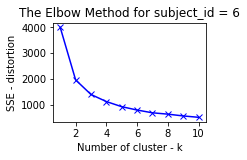

Text(0.5, 0, 'Answer')

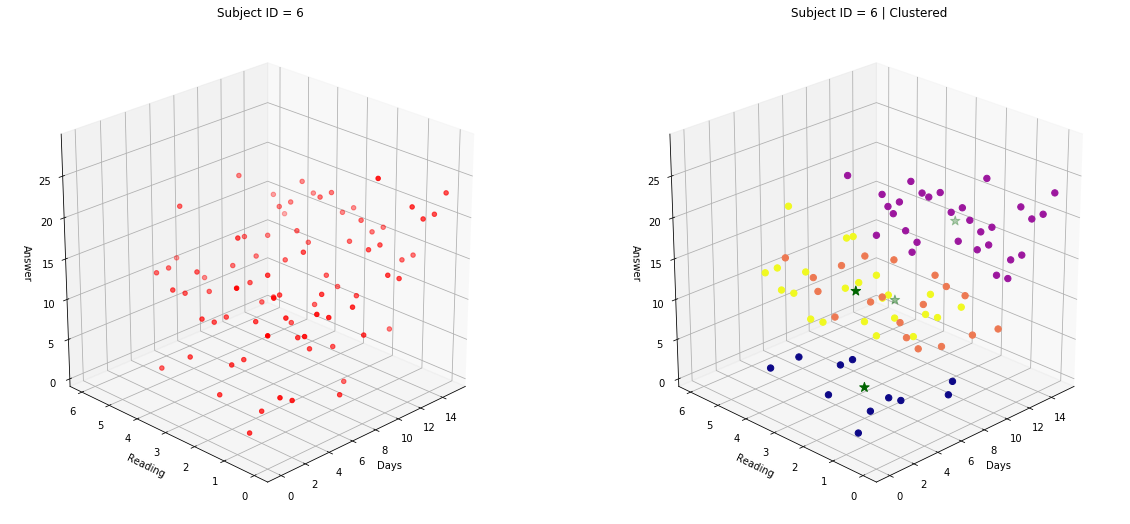

In [12]:
#clustering for subject_id = 6
#check number of clusters for subject_id = 6
sse = {}
#%matplotlib auto
for k in range (1, 11):
 
    #Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(sub_6)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    df_6["clusters"] = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    sse[k] = kmeans_model.inertia_
    #print ("k:",k, " cost:", interia)
fig = plt.figure()
fig.add_subplot(221)
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster - k")
plt.ylabel("SSE - distortion")
plt.title('The Elbow Method for subject_id = 6')
plt.show()
#we can see using the knee method, the results are best for k = 4

fig = plt.figure(figsize = (20,20))
                 #plt.figaspect(0.5))
    
#subject_id = 6
ax = fig.add_subplot(2, 2, 3, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.title.set_text('Subject ID = 6')
ax.xaxis._axinfo['label']['space_factor'] = 2.8
ax.scatter3D(sub_6[:,0],sub_6[:,1], sub_6[:,2], c ='red')
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')

#subject_id = 6, clustered data

# Initializing KMeans
kmeans = KMeans(n_clusters=4)
# Fitting with inputs
kmeans = kmeans.fit(sub_6)
# Predicting the clusters
labels = kmeans.predict(sub_6)
# Getting the cluster centers
C = kmeans.cluster_centers_

ax = fig.add_subplot(2, 2, 4, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.title.set_text('Subject ID = 6 | Clustered')
ax.xaxis._axinfo['label']['space_factor'] = 2.8
ax.scatter(sub_6[:,0],sub_6[:,1], sub_6[:,2], 
           c= kmeans.labels_.astype(float),
           cmap = cmap_light, s=40, alpha=1)

ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='darkgreen', s=100)
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')

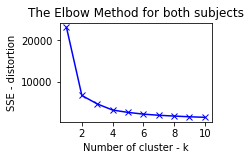

Text(0.5, 0, 'Answer')

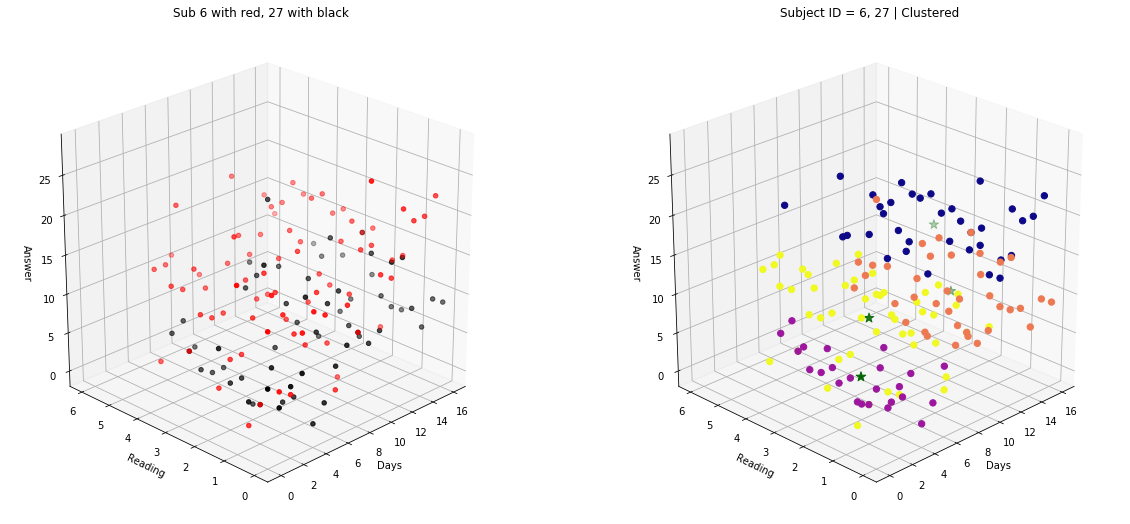

In [13]:
#all the points(both subjects)
#%matplotlib qt5
%matplotlib inline

f1 = df_scores['day'].values
f2 = df_scores['reading'].values
f3 = df_scores['answer'].values
f4 = df_scores['subject_id'].values
#X = np.array(list(zip(f1, f2, f3, f4)))
X = np.array(list(zip(f1, f2, f3, f4)))

sse = {}
#%matplotlib auto
for k in range (1, 11):
 
    #Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(X)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    df_scores["clusters"] = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    sse[k] = kmeans_model.inertia_
    #print ("k:",k, " cost:", interia)
fig = plt.figure()
fig.add_subplot(221)
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster - k")
plt.ylabel("SSE - distortion")
plt.title('The Elbow Method for both subjects')
plt.show()
#we can see using the knee method, the results are best for k = 4

#all the points(both subjects)
fig = plt.figure(figsize = (20,20))
                 #plt.figaspect(0.5))
    
#subject_id = 6
ax = fig.add_subplot(2, 2, 3, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.title.set_text('Sub 6 with red, 27 with black')
ax.xaxis._axinfo['label']['space_factor'] = 2.8
#for subject_id = 6
ax.scatter3D(sub_6[:,0],sub_6[:,1], sub_6[:,2], c ='red')
             #c= sub_6[:,2], cmap='plasma')

#for subject_id = 27
ax.scatter3D(sub_27[:,0],sub_27[:,1], sub_27[:,2], c ='black')
             #c=sub_27[:,2], cmap='binary')
    
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')

#subject_id = 6, clustered data

# Initializing KMeans
kmeans = KMeans(n_clusters=4)
# Fitting with inputs
kmeans = kmeans.fit(X)
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_

ax = fig.add_subplot(2, 2, 4, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.title.set_text('Subject ID = 6, 27 | Clustered')
ax.xaxis._axinfo['label']['space_factor'] = 2.8
ax.scatter(X[:,0],X[:,1], X[:,2], 
           c= kmeans.labels_.astype(float),
           cmap = cmap_light, s=40, alpha=1)

ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c='darkgreen', s=100)
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')

In [14]:
#for second clustering
cluster_id = kmeans.labels_

day = X[:,0]
reading = X[:,1]
answer = X[:,2]
subject_id = X[:,3]

df_cluster1 = pd.DataFrame(list(zip(cluster_id, day, reading ,subject_id, answer)))
df_cluster1.columns = ['cluster_id', 'day', 'reading', 'subject_id', 'answer']
df_cluster1.head(7)

,cluster_id,day,reading,subject_id,answer
0,3,0,0,6,15
1,3,0,1,6,19
2,3,1,0,6,7
3,3,1,1,6,1
4,3,1,2,6,4
5,3,1,3,6,7
6,3,1,4,6,4


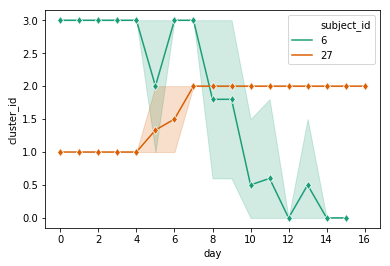

In [15]:
#variation of a subject in cluster_id within a day
import seaborn as sns
sns.lineplot(x="day", y="cluster_id", hue = "subject_id", data=df_cluster1, 
             palette=sns.color_palette('Dark2', n_colors=2), 
             marker = 'd')

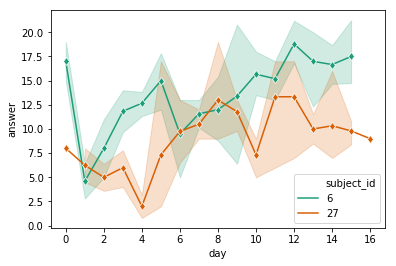

In [16]:
sns.lineplot(x="day", y="answer", hue = "subject_id", data=df_scores, 
             palette=sns.color_palette('Dark2', n_colors=2), 
             marker = 'd')

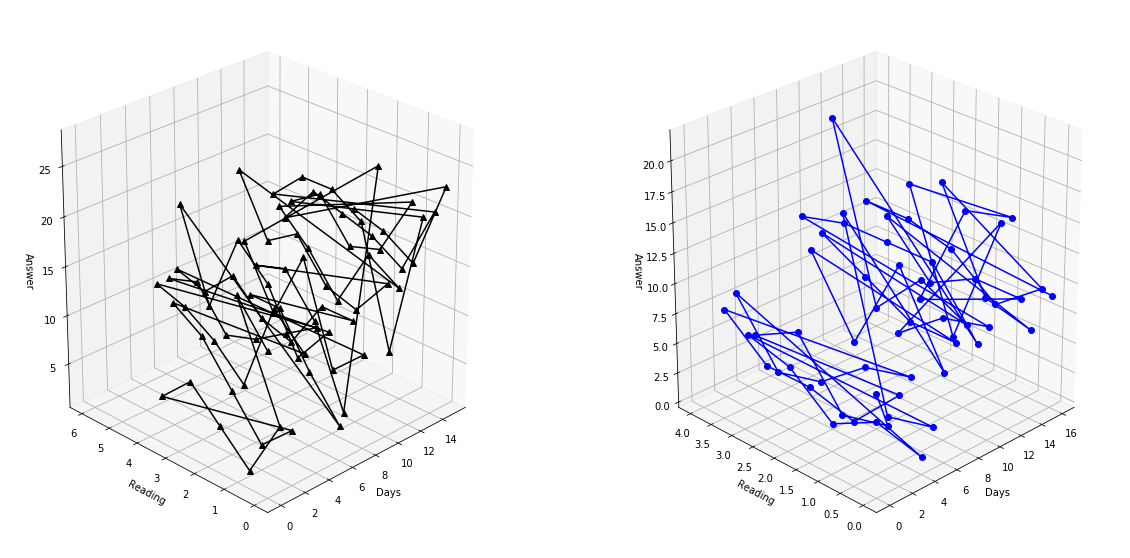

In [17]:
#%matplotlib qt5
%matplotlib inline

fig = plt.figure(figsize = (20,10))
                 #plt.figaspect(0.5))
    
#subject_id = 6
ax = fig.add_subplot(1, 2, 1, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.xaxis._axinfo['label']['space_factor'] = 2.8
ax.plot(sub_6[:,0],sub_6[:,1], sub_6[:,2],  marker = '^', c = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')
#scatter3D

#subject_id = 27
ax = fig.add_subplot(1, 2, 2, projection='3d')

tmp_planes = ax.zaxis._PLANES 
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
view_1 = (25, -135)
view_2 = (25, -45)
init_view = view_1
ax.view_init(*init_view)

ax.plot(sub_27[:,0],sub_27[:,1], sub_27[:,2], marker = 'o', c = 'blue')
ax.set_xlabel('Days')
ax.set_ylabel('Reading')
ax.set_zlabel('Answer')
plt.show()

In [18]:
print('run time = ', time.time()-t1)

run time =  39.50629210472107
